# Phase Map of a Subwavelength Binary Grating

We can also use the complex mode coefficients to compute the phase (or impedance) of the diffraction orders. This can be used to generate a phase map of the binary grating as a function of its geometric parameters. Phase maps are important for the design of subwavelength phase shifters such as those used in a metasurface lens. When the period of the unit cell is subwavelength, the zeroth-diffraction order is the only propagating wave. In this demonstration, which is adapted from the [previous example](https://meep.readthedocs.io/en/latest/Python_Tutorials/Mode_Decomposition/#diffraction-spectrum-of-a-binary-grating), we compute the transmittance spectra and phase map of the zeroth-diffraction order (at 0°) for an E<sub>z</sub>-polarized planewave pulse spanning wavelengths of 0.4 to 0.6 μm which is normally incident on a binary grating with a periodicity of 0.35 μm and height of 0.6 μm. The duty cycle of the grating is varied from 0.1 to 0.9 in separate runs.

In [3]:
import meep as mp
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

resolution = 50  # pixels/μm

dpml = 1.0  # PML thickness
dsub = 3.0  # substrate thickness
dpad = 3.0  # padding between grating and PML

wvl_min = 0.4  # min wavelength
wvl_max = 0.6  # max wavelength
fmin = 1 / wvl_max  # min frequency
fmax = 1 / wvl_min  # max frequency
fcen = 0.5 * (fmin + fmax)  # center frequency
df = fmax - fmin  # frequency width
nfreq = 21  # number of frequency bins

k_point = mp.Vector3(0, 0, 0)

glass = mp.Medium(index=1.5)


def grating(gp, gh, gdc, oddz):
    sx = dpml + dsub + gh + dpad + dpml
    sy = gp

    cell_size = mp.Vector3(sx, sy, 0)
    pml_layers = [mp.PML(thickness=dpml, direction=mp.X)]

    src_pt = mp.Vector3(-0.5 * sx + dpml + 0.5 * dsub, 0, 0)
    sources = [
        mp.Source(
            mp.GaussianSource(fcen, fwidth=df),
            component=mp.Ez if oddz else mp.Hz,
            center=src_pt,
            size=mp.Vector3(0, sy, 0),
        )
    ]

    symmetries = [mp.Mirror(mp.Y, phase=+1 if oddz else -1)]

    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        k_point=k_point,
        default_material=glass,
        sources=sources,
        symmetries=symmetries,
    )

    mon_pt = mp.Vector3(0.5 * sx - dpml - 0.5 * dpad, 0, 0)
    flux_mon = sim.add_flux(
        fcen, df, nfreq, mp.FluxRegion(center=mon_pt, size=mp.Vector3(0, sy, 0))
    )

    sim.run(until_after_sources=100)

    input_flux = mp.get_fluxes(flux_mon)

    sim.reset_meep()

    geometry = [
        mp.Block(
            material=glass,
            size=mp.Vector3(dpml + dsub, mp.inf, mp.inf),
            center=mp.Vector3(-0.5 * sx + 0.5 * (dpml + dsub), 0, 0),
        ),
        mp.Block(
            material=glass,
            size=mp.Vector3(gh, gdc * gp, mp.inf),
            center=mp.Vector3(-0.5 * sx + dpml + dsub + 0.5 * gh, 0, 0),
        ),
    ]

    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        geometry=geometry,
        k_point=k_point,
        sources=sources,
        symmetries=symmetries,
    )

    mode_mon = sim.add_flux(
        fcen, df, nfreq, mp.FluxRegion(center=mon_pt, size=mp.Vector3(0, sy, 0))
    )

    sim.run(until_after_sources=300)

    freqs = mp.get_eigenmode_freqs(mode_mon)
    res = sim.get_eigenmode_coefficients(
        mode_mon, [1], eig_parity=mp.ODD_Z + mp.EVEN_Y if oddz else mp.EVEN_Z + mp.ODD_Y
    )
    coeffs = res.alpha

    mode_wvl = [1 / freqs[nf] for nf in range(nfreq)]
    mode_tran = [abs(coeffs[0, nf, 0]) ** 2 / input_flux[nf] for nf in range(nfreq)]
    mode_phase = [np.angle(coeffs[0, nf, 0]) for nf in range(nfreq)]

    return mode_wvl, mode_tran, mode_phase


gp = 0.35
gh = 0.6
gdc = np.linspace(0.1, 1.0, 10)
mode_tran = np.empty((gdc.size, nfreq))
mode_phase = np.empty((gdc.size, nfreq))
for n in range(gdc.size):
    mode_wvl, mode_tran[n, :], mode_phase[n, :] = grating(gp, gh, gdc[n], True)

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00244403 s
Working in 2D dimensions.
Computational cell is 8.6 x 0.36 x 0 with resolution 50
time for set_epsilon = 0.0124252 s
-----------
run 0 finished at t = 112.0 (11200 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00123405 s
Working in 2D dimensions.
Computational cell is 8.6 x 0.36 x 0 with resolution 50
     block, center = (-2.3,0,0)
          size (4,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (1.66533e-16,0,0)
          size (0.6,0.035,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
time for set_epsilon = 0.014374 s
-----------
Meep progress: 266.34000000000003/312.0 = 85.4% done in 4.0s, 0.7s to go
on time step 26634 

Dominant planewave for band 1: (1.666667,-0.000000,0.000000)
MPB solved for omega_1(1.70833,0,0) = 1.70833 after 7 iters
Dominant planewave for band 1: (1.708333,-0.000000,0.000000)
MPB solved for omega_1(1.75,0,0) = 1.75 after 8 iters
Dominant planewave for band 1: (1.750000,-0.000000,0.000000)
MPB solved for omega_1(1.79167,0,0) = 1.79167 after 8 iters
Dominant planewave for band 1: (1.791667,-0.000000,0.000000)
MPB solved for omega_1(1.83333,0,0) = 1.83333 after 8 iters
Dominant planewave for band 1: (1.833333,-0.000000,0.000000)
MPB solved for omega_1(1.875,0,0) = 1.875 after 8 iters
Dominant planewave for band 1: (1.875000,-0.000000,0.000000)
MPB solved for omega_1(1.91667,0,0) = 1.91667 after 9 iters
Dominant planewave for band 1: (1.916667,-0.000000,0.000000)
MPB solved for omega_1(1.95833,0,0) = 1.95833 after 8 iters
Dominant planewave for band 1: (1.958333,-0.000000,0.000000)
MPB solved for omega_1(2,0,0) = 2 after 8 iters
Dominant planewave for band 1: (2.000000,-0.000000,0.0

Dominant planewave for band 1: (2.041667,-0.000000,0.000000)
MPB solved for omega_1(2.08333,0,0) = 2.08333 after 9 iters
Dominant planewave for band 1: (2.083333,-0.000000,0.000000)
MPB solved for omega_1(2.125,0,0) = 2.125 after 9 iters
Dominant planewave for band 1: (2.125000,-0.000000,0.000000)
MPB solved for omega_1(2.16667,0,0) = 2.16667 after 9 iters
Dominant planewave for band 1: (2.166667,-0.000000,0.000000)
MPB solved for omega_1(2.20833,0,0) = 2.20833 after 8 iters
Dominant planewave for band 1: (2.208333,-0.000000,0.000000)
MPB solved for omega_1(2.25,0,0) = 2.25 after 9 iters
Dominant planewave for band 1: (2.250000,-0.000000,0.000000)
MPB solved for omega_1(2.29167,0,0) = 2.29167 after 9 iters
Dominant planewave for band 1: (2.291667,-0.000000,0.000000)
MPB solved for omega_1(2.33333,0,0) = 2.33333 after 10 iters
Dominant planewave for band 1: (2.333333,-0.000000,0.000000)
MPB solved for omega_1(2.375,0,0) = 2.375 after 9 iters
Dominant planewave for band 1: (2.375000,-0.0

Dominant planewave for band 1: (2.416667,-0.000000,0.000000)
MPB solved for omega_1(2.45833,0,0) = 2.45833 after 9 iters
Dominant planewave for band 1: (2.458333,-0.000000,0.000000)
MPB solved for omega_1(2.5,0,0) = 2.5 after 9 iters
Dominant planewave for band 1: (2.500000,-0.000000,0.000000)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.000772953 s
Working in 2D dimensions.
Computational cell is 8.6 x 0.36 x 0 with resolution 50
time for set_epsilon = 0.0116861 s
-----------
run 0 finished at t = 112.0 (11200 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00118494 s
Working in 2D dimensions.
Computational cell is 8.6 x 0.36 x 0 with resolution 50
     block, center = (-2.3,0,0)
          size (4,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = 

          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
time for set_epsilon = 0.0155971 s
-----------
Meep progress: 266.89/312.0 = 85.5% done in 4.0s, 0.7s to go
on time step 26689 (time=266.89), 0.000149884 s/step
run 0 finished at t = 312.0 (31200 timesteps)
MPB solved for omega_1(1.66667,0,0) = 1.66667 after 8 iters
Dominant planewave for band 1: (1.666667,-0.000000,0.000000)
MPB solved for omega_1(1.70833,0,0) = 1.70833 after 8 iters
Dominant planewave for band 1: (1.708333,-0.000000,0.000000)
MPB solved for omega_1(1.75,0,0) = 1.75 after 7 iters
Dominant planewave for band 1: (1.750000,-0.000000,0.000000)
MPB solved for omega_1(1.79167,0,0) = 1.79167 after 8 iters
Dominant planewave for band 1: (1.791667,-0.000000,0.000000)
MPB solved for omega_1(1.83333,0,0) = 1.83333 after 8 iters
Dominant planewave for band 1: (1.833333,-0.000000,0.000000)
MPB solved for omega_1(1.875,0,0) = 1.875 after 8 iters
Dominant planewave for band 1: (1.875000,-0.000000,0.000000)
MPB solved 

The phase of the zeroth-diffraction order is simply the angle of its complex mode coefficient. Note that it is generally only the relative phase (the phase difference) between different structures that is useful. The overall mode coefficient α is multiplied by a complex number given by the source amplitude, as well as an arbitrary (but deterministic) phase choice by the mode solver MPB (i.e., which maximizes the energy in the real part of the fields via [`ModeSolver.fix_field_phase`](https://mpb.readthedocs.io/en/latest/Python_User_Interface/#loading-and-manipulating-the-current-field)) — but as long as you keep the current source fixed as you vary the parameters of the structure, the relative phases are meaningful.

The figure below shows the transmittance spectra (left) and phase map (right). The transmittance is nearly unity over most of the parameter space mainly because of the subwavelength dimensions of the grating. The phase variation spans the full range of -π to +π at each wavelength but varies weakly with the duty cycle due to the relatively low index of the glass grating. Higher-index materials such as [titanium dioxide](https://en.wikipedia.org/wiki/Titanium_dioxide#Thin_films) (TiO<sub>2</sub>) generally provide more control over the phase

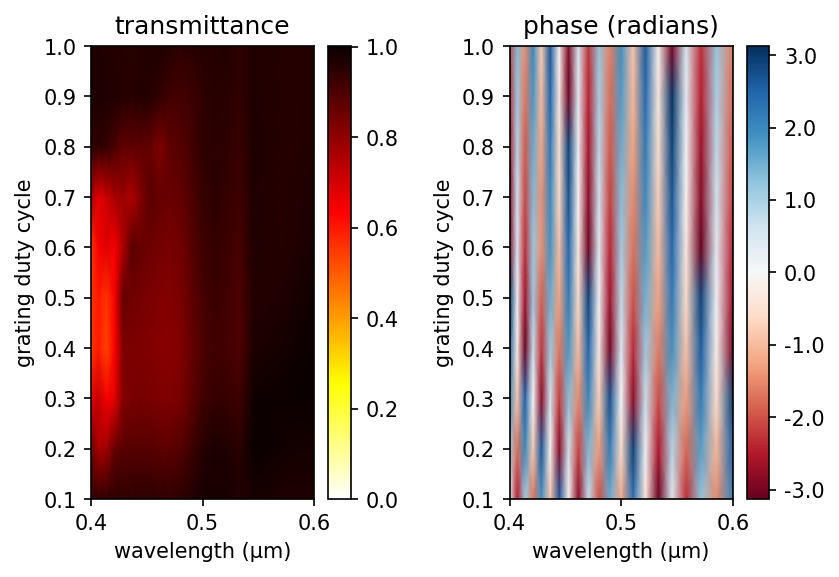

In [4]:
plt.figure(dpi=150)
plt.subplot(1, 2, 1)
plt.pcolormesh(
    mode_wvl,
    gdc,
    mode_tran,
    cmap="hot_r",
    shading="gouraud",
    vmin=0,
    vmax=mode_tran.max(),
)
plt.axis([wvl_min, wvl_max, gdc[0], gdc[-1]])
plt.xlabel("wavelength (μm)")
plt.xticks([t for t in np.linspace(wvl_min, wvl_max, 3)])
plt.ylabel("grating duty cycle")
plt.yticks([t for t in np.arange(gdc[0], gdc[-1] + 0.1, 0.1)])
plt.title("transmittance")
cbar = plt.colorbar()
cbar.set_ticks([t for t in np.arange(0, 1.2, 0.2)])
cbar.set_ticklabels(["{:.1f}".format(t) for t in np.linspace(0, 1, 6)])

plt.subplot(1, 2, 2)
plt.pcolormesh(
    mode_wvl,
    gdc,
    mode_phase,
    cmap="RdBu",
    shading="gouraud",
    vmin=mode_phase.min(),
    vmax=mode_phase.max(),
)
plt.axis([wvl_min, wvl_max, gdc[0], gdc[-1]])
plt.xlabel("wavelength (μm)")
plt.xticks([t for t in np.linspace(wvl_min, wvl_max, 3)])
plt.ylabel("grating duty cycle")
plt.yticks([t for t in np.arange(gdc[0], gdc[-1] + 0.1, 0.1)])
plt.title("phase (radians)")
cbar = plt.colorbar()
cbar.set_ticks([t for t in range(-3, 4)])
cbar.set_ticklabels(["{:.1f}".format(t) for t in range(-3, 4)])

plt.subplots_adjust(wspace=0.5)

See [Tutorials/Near to Far Field Spectra/Focusing Properties of a Metasurface Lens](https://meep.readthedocs.io/en/latest/Python_Tutorials/Near_to_Far_Field_Spectra/#focusing-properties-of-a-metasurface-lens) for a related example.